# Lab 1: Day-ahead load prediction for ERCOT (Texas) markets. 

Ke Xu 3190110360

In this lab, you train a neural network to predict 24-hour aggregate load from Texas for a day using history of demands. The goals for this lab are:
1. Load the data and analyze to find patterns.
2. Define a neural network for the regression. Try different number of layers, learning rates, linear v/s nonlinear regression, activation functions, number of epochs, etc.
3. Explore the effects of wind energy on load prediction. 

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import random
import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt

# The following line suppresses certain warnings.
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

## Load the ERCOT data from 2015.

The load data is given in the column named 'ERCOT Load, MW' in the csv file provided.

In [2]:
year = 2015
dfDemand = pd.read_csv("ERCOT_Hourly_Wind_Output_" + str(year) + ".csv")

demands = dfDemand['ERCOT Load, MW']

# Count the number of days for which we have demand data.
numberOfDays = int(len(demands)/24)
print("Hourly demand data loaded for %d days." % numberOfDays)


Hourly demand data loaded for 365 days.


## Understand the data.

It is always useful to get accustomed to the data you are trying to learn. Visualize it if you can.

#### Q1. How does load vary over the year in Texas?

Text(0, 0.5, 'Net demand of Texas (in MW)')

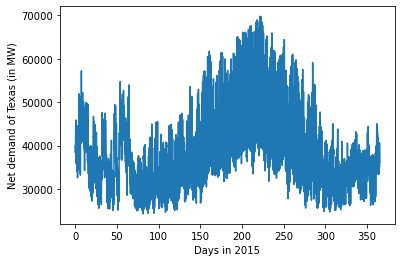

In [3]:
fig = plt.figure()

plt.plot([hour/24 for hour in range(numberOfDays * 24)], demands.values)
plt.xlabel("Days in " + str(year))
plt.ylabel("Net demand of Texas (in MW)")

**Fact.** A significant portion of the demand is usually thermal, i.e., for air conditioners and heating systems.

**Question (10 points).** From the above plot, what can you infer about the climate of Texas? What would you expect if you plotted the same in Illinois? 

**Your answer.** As the fact mentioned, a significant portion of the demand is usually thermal, such as air conditioners and heating systems, thus the peak demand (around day-200) in summer indicates hot weather (roughly between day-150 and day-250) and the peak demand (around day-10) in winter indicates cold weather (roughly between day 360 and day 20). Based on my understanding and experience, Illinois has long cold winters and short hot summers because of higher Latitude and close distance to Great Lakes, so if I plotted the same in Illinois, the peak will be shorter around day-200 (roughly between day-180 to day-220) and longer around day-10 (roughly between day-300 to day-90).

#### Q2. How does day of week affect the load profiles?

The first day in the first plot is Jan 31, 2015.
Day 1 was a Saturday.


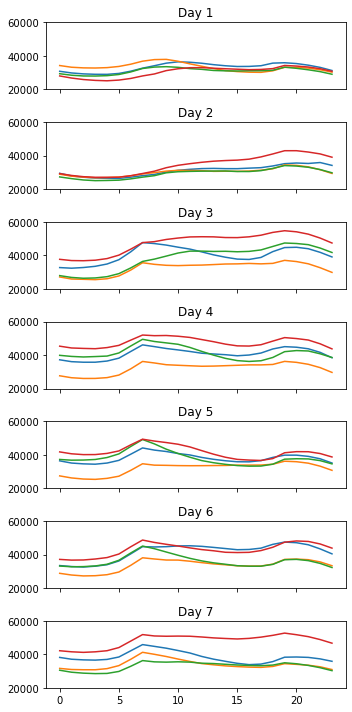

In [4]:
# Plot the load data of the same day of the week over several weeks.

dayStart = 30
numberOfWeeks = 4

DayOfWeek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
print("The first day in the first plot is Jan 31, " + str(year) + ".")
print("Day 1", "was a", DayOfWeek[datetime.date(year, 1, 31).weekday()] + ".")

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(5,10))
axs = axs.ravel()

for dayInFirstWeek in range(7):
    for week in range(numberOfWeeks):

        axs[dayInFirstWeek].plot(range(24), dfDemand.loc[(dayStart + 7 * week + dayInFirstWeek) * 24: 
                                                         (dayStart + 7 * week + dayInFirstWeek + 1) * 24 - 1, 
                                                         'ERCOT Load, MW'].values.flatten())
    axs[dayInFirstWeek].set_ylim(bottom=20000, top=60000)
    axs[dayInFirstWeek].set_title("Day " + str(dayInFirstWeek + 1))

fig.tight_layout()
plt.show()

The first day in the first plot is Aug 15, 2015.
Day 1 was a Saturday.


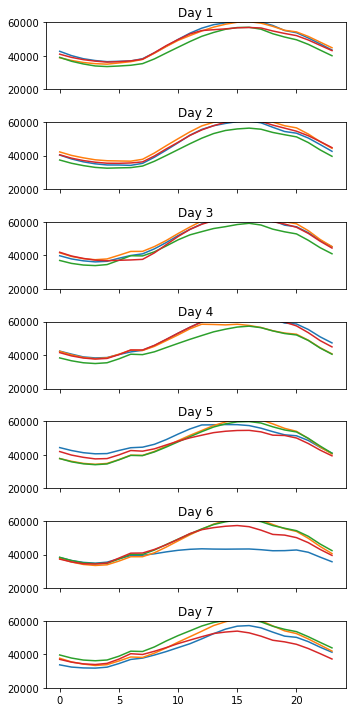

In [5]:
# Plot the load data of the same day of the week over several weeks.

dayStart = 226
numberOfWeeks = 4

DayOfWeek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
print("The first day in the first plot is Aug 15, " + str(year) + ".")
print("Day 1", "was a", DayOfWeek[datetime.date(year, 1, 31).weekday()] + ".")

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(5,10))
axs = axs.ravel()

for dayInFirstWeek in range(7):
    for week in range(numberOfWeeks):

        axs[dayInFirstWeek].plot(range(24), dfDemand.loc[(dayStart + 7 * week + dayInFirstWeek) * 24: 
                                                         (dayStart + 7 * week + dayInFirstWeek + 1) * 24 - 1, 
                                                         'ERCOT Load, MW'].values.flatten())
    axs[dayInFirstWeek].set_ylim(bottom=20000, top=60000)
    axs[dayInFirstWeek].set_title("Day " + str(dayInFirstWeek + 1))

fig.tight_layout()
plt.show()

**Question (15 points).** Can you find any discernible change in the load profiles of different days of the week? Redo the above exercise for the months of August and September. Make 'Day 1' correspond to August 15th. What do you observe differently? 

**Your answer.** Given that day-1 was Saturday, I observed that the curves on days-1 and day-2 (i.e. Saturday and Sunday) were smooth across the whole day while the curve from day-3 to day-7 (i.e. from Monday to Friday) had a turning point around 7 o'clock. Given day-1 to be August 15th, the differences between the different days of the week are not as great as before, with increased demand around 15 o'clock even above the threshold we setup for plots (i.e. 60000), which is quite different from the case on January 31.

## Define the demand prediction module.

Use past demand profiles to predict demands a day in advance. We draw two conclusions from the above analysis:
1. Demand profiles have seasonal effects. Therefore, data from the past few days will help in predicting the demands tomorrow.
2. Demand profiles have weekly dependencies. Therefore, data from the same days but a week or two before can be useful in load prediction.

How much past data you want to train over depends on two considerations:
1. Which data in the past is useful in prediction?
2. How complex you want your training process to be? The more features of past data you want to train on, the more complex your neural network should be, and it will require more time to train it.

To strike a balance, use the demand profile from $d-7, d-2, d-1$ to predict the load profile of day $d$.

In [6]:
daysToTrainOn = [-7, -2, -1]
rangeOfDays = range(-np.min(daysToTrainOn), numberOfDays)

X = [np.concatenate([dfDemand.loc[(day + h) * 24: (day + h + 1) * 24 -1, 'ERCOT Load, MW'].values.flatten()
     for h in daysToTrainOn]) for day in rangeOfDays]
Y = [dfDemand.loc[day * 24: (day + 1) * 24 - 1, 'ERCOT Load, MW'].values.flatten() for day in rangeOfDays]


When you perform regression, it is often desirable to scale the inputs so that it has zero mean and unit variance. Other types of scaling are possible. Here, we cheat a little and scale both the training and test data together. Ideally, they should be scaled separately.

Split the data into two sets: training set and testing set. Train the neural network on the training set, and test how well it performs on the testing set. You should typically never sample from the training set to test your algorithms. The learnt model for prediction should work well on data that the algorithm has never encountered before.

The function 'train_test_split' helps you to split the data into two parts, where 'test_size'
indicates the fraction of the data you want to test on.

In [7]:
X = preprocessing.StandardScaler().fit_transform(X)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2)

trainX = trainX.astype(np.float32)
testX = testX.astype(np.float32)
trainY = np.array(trainY)
testY = np.array(testY)

print("Scaled and split the data into two parts:")

nTrain = np.shape(trainX)[0]
nTest = np.shape(testX)[0]

print("Neural network will train on data from %d days, and test on %d days." % (nTrain, nTest))

Scaled and split the data into two parts:
Neural network will train on data from 286 days, and test on 72 days.


### Design the neural network (NN) for demand prediction with only one hidden layer.

**Question (25 points). Insert code to design the NN and its optimizer (use the relu function)** 

In [8]:
nHidden = 150

# Store the dimension of each row of 'X' in 'nDimX' and that of 'Y' in 'nDimY' .
nDimX = np.shape(trainX)[1]
nDimY = np.shape(trainY)[1]

# Construct the neural network using relu
inputs = keras.Input(shape=nDimX, name="input")
nn_layer = keras.layers.Dense(nHidden, activation="relu")(inputs)
outputs = keras.layers.Dense(nDimY, name="output")(nn_layer)

model = keras.Model(inputs=inputs, outputs=outputs)

# Define the loss function (MSE) and the optimizer (AdagradOptimizer).

model.compile(
    optimizer=tf.optimizers.Adagrad(learning_rate=1),
    loss='mean_squared_error'
)


### Train the neural network via Keras.

Create the training module for the NN. 

Keras is a user-friendly framework to define, train and test neural networks. Check their page out for more details. https://keras.io/ 

Feed the training data in batches of size 'batchSize'.Usually, going through the training data once does not train your NN. You train over the same data multiple times. More precisely, train it 'nEpochs' times. It is similar to the idea that you never learn a material by reading through it once!

**Question (20 points). Insert code to define the training module**

In [9]:
batchSize = 50
nEpochs = 1000

# Train the model

print("Fit model on training data")

history = model.fit(
    trainX,
    trainY,
    batch_size = batchSize,
    epochs = nEpochs
)

Fit model on training data
Epoch 1/1000
6/6 [==============================] - 0s 1ms/step - loss: 836097536.0000
Epoch 2/1000
6/6 [==============================] - 0s 1ms/step - loss: 341600512.0000
Epoch 3/1000
6/6 [==============================] - 0s 2ms/step - loss: 319399776.0000
Epoch 4/1000
6/6 [==============================] - 0s 2ms/step - loss: 290163424.0000
Epoch 5/1000
6/6 [==============================] - 0s 2ms/step - loss: 263106896.0000
Epoch 6/1000
6/6 [==============================] - 0s 2ms/step - loss: 237009024.0000
Epoch 7/1000
6/6 [==============================] - 0s 3ms/step - loss: 229609952.0000
Epoch 8/1000
6/6 [==============================] - 0s 3ms/step - loss: 191741728.0000
Epoch 9/1000
6/6 [==============================] - 0s 2ms/step - loss: 173253136.0000
Epoch 10/1000
6/6 [==============================] - 0s 3ms/step - loss: 151441200.0000
Epoch 11/1000
6/6 [==============================] - 0s 2ms/step - loss: 134201576.0000
Epoch 12/1000


6/6 [==============================] - 0s 2ms/step - loss: 24533026.0000
Epoch 95/1000
6/6 [==============================] - 0s 2ms/step - loss: 24362798.0000
Epoch 96/1000
6/6 [==============================] - 0s 6ms/step - loss: 25369438.0000
Epoch 97/1000
6/6 [==============================] - 0s 4ms/step - loss: 23872692.0000
Epoch 98/1000
6/6 [==============================] - 0s 3ms/step - loss: 23632682.0000
Epoch 99/1000
6/6 [==============================] - 0s 3ms/step - loss: 23562874.0000
Epoch 100/1000
6/6 [==============================] - 0s 3ms/step - loss: 23109444.0000
Epoch 101/1000
6/6 [==============================] - 0s 2ms/step - loss: 22954230.0000
Epoch 102/1000
6/6 [==============================] - 0s 2ms/step - loss: 22655676.0000
Epoch 103/1000
6/6 [==============================] - 0s 2ms/step - loss: 22436404.0000
Epoch 104/1000
6/6 [==============================] - 0s 1ms/step - loss: 22110196.0000
Epoch 105/1000
6/6 [==============================] 

6/6 [==============================] - 0s 4ms/step - loss: 10788883.0000
Epoch 188/1000
6/6 [==============================] - 0s 2ms/step - loss: 11182245.0000
Epoch 189/1000
6/6 [==============================] - 0s 1ms/step - loss: 11137169.0000
Epoch 190/1000
6/6 [==============================] - 0s 1ms/step - loss: 10951201.0000
Epoch 191/1000
6/6 [==============================] - 0s 3ms/step - loss: 11258586.0000
Epoch 192/1000
6/6 [==============================] - 0s 2ms/step - loss: 10936535.0000
Epoch 193/1000
6/6 [==============================] - 0s 2ms/step - loss: 10544943.0000
Epoch 194/1000
6/6 [==============================] - 0s 2ms/step - loss: 11708110.0000
Epoch 195/1000
6/6 [==============================] - 0s 2ms/step - loss: 10411272.0000
Epoch 196/1000
6/6 [==============================] - 0s 3ms/step - loss: 10316175.0000
Epoch 197/1000
6/6 [==============================] - 0s 3ms/step - loss: 10374884.0000
Epoch 198/1000
6/6 [===========================

6/6 [==============================] - 0s 3ms/step - loss: 8523295.0000
Epoch 282/1000
6/6 [==============================] - 0s 2ms/step - loss: 7421994.5000
Epoch 283/1000
6/6 [==============================] - 0s 2ms/step - loss: 7278509.0000
Epoch 284/1000
6/6 [==============================] - 0s 1ms/step - loss: 7270367.5000
Epoch 285/1000
6/6 [==============================] - 0s 2ms/step - loss: 7254129.5000
Epoch 286/1000
6/6 [==============================] - 0s 2ms/step - loss: 7404882.0000
Epoch 287/1000
6/6 [==============================] - 0s 1ms/step - loss: 7722117.5000
Epoch 288/1000
6/6 [==============================] - 0s 1ms/step - loss: 7080102.5000
Epoch 289/1000
6/6 [==============================] - 0s 2ms/step - loss: 7395847.0000
Epoch 290/1000
6/6 [==============================] - 0s 1ms/step - loss: 7718138.5000
Epoch 291/1000
6/6 [==============================] - 0s 998us/step - loss: 7621967.0000
Epoch 292/1000
6/6 [==============================] - 0s

6/6 [==============================] - 0s 1ms/step - loss: 5869095.0000
Epoch 376/1000
6/6 [==============================] - 0s 1ms/step - loss: 5791573.0000
Epoch 377/1000
6/6 [==============================] - 0s 1ms/step - loss: 6013912.5000
Epoch 378/1000
6/6 [==============================] - 0s 1ms/step - loss: 5981284.5000
Epoch 379/1000
6/6 [==============================] - 0s 2ms/step - loss: 5732665.5000
Epoch 380/1000
6/6 [==============================] - 0s 1ms/step - loss: 5689771.0000
Epoch 381/1000
6/6 [==============================] - 0s 1ms/step - loss: 5742448.5000
Epoch 382/1000
6/6 [==============================] - 0s 1ms/step - loss: 5684075.0000
Epoch 383/1000
6/6 [==============================] - 0s 2ms/step - loss: 5971545.0000
Epoch 384/1000
6/6 [==============================] - 0s 1ms/step - loss: 5996883.5000
Epoch 385/1000
6/6 [==============================] - 0s 1ms/step - loss: 5652371.0000
Epoch 386/1000
6/6 [==============================] - 0s 1

6/6 [==============================] - 0s 1ms/step - loss: 5038484.5000
Epoch 470/1000
6/6 [==============================] - 0s 2ms/step - loss: 5116043.0000
Epoch 471/1000
6/6 [==============================] - 0s 2ms/step - loss: 5019689.0000
Epoch 472/1000
6/6 [==============================] - 0s 2ms/step - loss: 6265360.0000
Epoch 473/1000
6/6 [==============================] - 0s 2ms/step - loss: 5021382.5000
Epoch 474/1000
6/6 [==============================] - 0s 2ms/step - loss: 4964264.0000
Epoch 475/1000
6/6 [==============================] - 0s 1ms/step - loss: 5136761.5000
Epoch 476/1000
6/6 [==============================] - 0s 1ms/step - loss: 5056278.0000
Epoch 477/1000
6/6 [==============================] - 0s 2ms/step - loss: 4976202.5000
Epoch 478/1000
6/6 [==============================] - 0s 2ms/step - loss: 4928289.0000
Epoch 479/1000
6/6 [==============================] - 0s 1ms/step - loss: 4998103.5000
Epoch 480/1000
6/6 [==============================] - 0s 1

6/6 [==============================] - 0s 1ms/step - loss: 4705965.0000
Epoch 564/1000
6/6 [==============================] - 0s 2ms/step - loss: 4735999.0000
Epoch 565/1000
6/6 [==============================] - ETA: 0s - loss: 6134546.000 - 0s 2ms/step - loss: 4708874.0000
Epoch 566/1000
6/6 [==============================] - 0s 1ms/step - loss: 5483422.5000
Epoch 567/1000
6/6 [==============================] - 0s 1ms/step - loss: 4716012.5000
Epoch 568/1000
6/6 [==============================] - 0s 1ms/step - loss: 4823148.5000
Epoch 569/1000
6/6 [==============================] - 0s 1ms/step - loss: 4572160.0000
Epoch 570/1000
6/6 [==============================] - 0s 1ms/step - loss: 4674380.0000
Epoch 571/1000
6/6 [==============================] - 0s 1ms/step - loss: 4517044.0000
Epoch 572/1000
6/6 [==============================] - 0s 1ms/step - loss: 4552460.5000
Epoch 573/1000
6/6 [==============================] - 0s 1ms/step - loss: 4534067.5000
Epoch 574/1000
6/6 [========

Epoch 657/1000
6/6 [==============================] - 0s 2ms/step - loss: 4248709.5000
Epoch 658/1000
6/6 [==============================] - 0s 1ms/step - loss: 4362340.5000
Epoch 659/1000
6/6 [==============================] - 0s 1ms/step - loss: 4385976.0000
Epoch 660/1000
6/6 [==============================] - 0s 1ms/step - loss: 4341393.0000
Epoch 661/1000
6/6 [==============================] - 0s 1ms/step - loss: 4358255.5000
Epoch 662/1000
6/6 [==============================] - 0s 1ms/step - loss: 4481653.0000
Epoch 663/1000
6/6 [==============================] - 0s 1ms/step - loss: 4288932.5000
Epoch 664/1000
6/6 [==============================] - 0s 1ms/step - loss: 4502103.5000
Epoch 665/1000
6/6 [==============================] - 0s 1ms/step - loss: 4633287.5000
Epoch 666/1000
6/6 [==============================] - 0s 1ms/step - loss: 4336134.0000
Epoch 667/1000
6/6 [==============================] - 0s 1ms/step - loss: 4212224.0000
Epoch 668/1000
6/6 [=======================

6/6 [==============================] - 0s 2ms/step - loss: 4065176.2500
Epoch 752/1000
6/6 [==============================] - 0s 6ms/step - loss: 4356742.0000
Epoch 753/1000
6/6 [==============================] - 0s 4ms/step - loss: 4158420.2500
Epoch 754/1000
6/6 [==============================] - 0s 3ms/step - loss: 4135939.5000
Epoch 755/1000
6/6 [==============================] - 0s 4ms/step - loss: 4287717.5000
Epoch 756/1000
6/6 [==============================] - 0s 4ms/step - loss: 4044685.7500
Epoch 757/1000
6/6 [==============================] - 0s 5ms/step - loss: 4088903.2500
Epoch 758/1000
6/6 [==============================] - 0s 6ms/step - loss: 4038155.2500
Epoch 759/1000
6/6 [==============================] - 0s 4ms/step - loss: 4015435.7500
Epoch 760/1000
6/6 [==============================] - 0s 4ms/step - loss: 4040176.7500
Epoch 761/1000
6/6 [==============================] - 0s 2ms/step - loss: 4201304.0000
Epoch 762/1000
6/6 [==============================] - 0s 2

6/6 [==============================] - 0s 1ms/step - loss: 3912896.0000
Epoch 846/1000
6/6 [==============================] - 0s 2ms/step - loss: 3933453.7500
Epoch 847/1000
6/6 [==============================] - 0s 1ms/step - loss: 4045147.2500
Epoch 848/1000
6/6 [==============================] - 0s 2ms/step - loss: 3867708.7500
Epoch 849/1000
6/6 [==============================] - 0s 2ms/step - loss: 3869842.7500
Epoch 850/1000
6/6 [==============================] - 0s 2ms/step - loss: 4143232.0000
Epoch 851/1000
6/6 [==============================] - 0s 2ms/step - loss: 3944327.2500
Epoch 852/1000
6/6 [==============================] - 0s 2ms/step - loss: 4026006.5000
Epoch 853/1000
6/6 [==============================] - 0s 2ms/step - loss: 3934663.5000
Epoch 854/1000
6/6 [==============================] - 0s 3ms/step - loss: 3858476.2500
Epoch 855/1000
6/6 [==============================] - 0s 2ms/step - loss: 3957076.2500
Epoch 856/1000
6/6 [==============================] - 0s 1

6/6 [==============================] - 0s 1ms/step - loss: 3769213.7500
Epoch 940/1000
6/6 [==============================] - 0s 1ms/step - loss: 3731410.2500
Epoch 941/1000
6/6 [==============================] - 0s 1ms/step - loss: 3759115.2500
Epoch 942/1000
6/6 [==============================] - 0s 1ms/step - loss: 3716111.2500
Epoch 943/1000
6/6 [==============================] - 0s 1ms/step - loss: 3891198.2500
Epoch 944/1000
6/6 [==============================] - 0s 992us/step - loss: 3819137.7500
Epoch 945/1000
6/6 [==============================] - 0s 1ms/step - loss: 3733769.5000
Epoch 946/1000
6/6 [==============================] - 0s 999us/step - loss: 3735865.2500
Epoch 947/1000
6/6 [==============================] - 0s 1ms/step - loss: 3739627.0000
Epoch 948/1000
6/6 [==============================] - 0s 1ms/step - loss: 3722247.5000
Epoch 949/1000
6/6 [==============================] - 0s 1ms/step - loss: 3864423.5000
Epoch 950/1000
6/6 [==============================] - 

### Let us visualize the results.

**Question (5 points). Usine the NN to predict on test data**


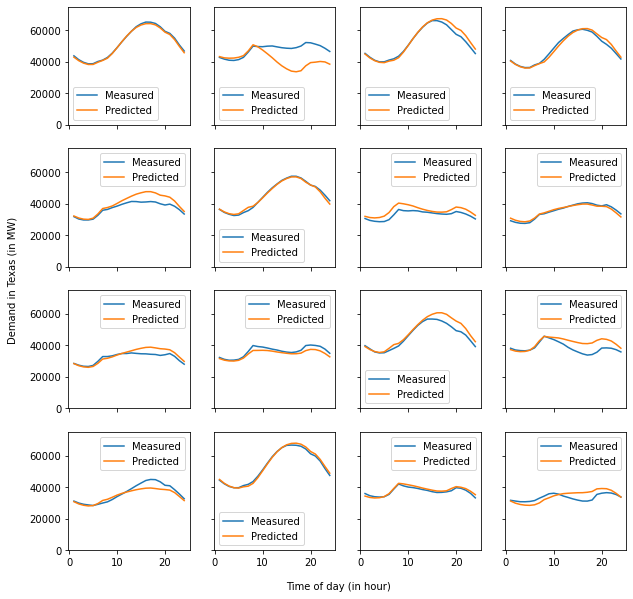

In [10]:
# Output the accuracy of the regressor on the test data.

predictedY = model.predict(testX)

# Plot the predicted load and compare against the actual load from the test data.
assert(nTest >= 16)
days = random.sample(range(nTest), 16)

fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(10,10))
axs = axs.ravel()


for dd, day in enumerate(days):
    testYDay = testY[day]
    predictedYDay = predictedY[day]

    l1 = axs[dd].plot(range(1, 25), testYDay, label='Measured')
    l2 = axs[dd].plot(range(1, 25), predictedYDay, label='Predicted')
    
    axs[dd].set_ylim(bottom=0, top=75000)
    axs[dd].legend()

fig.text(0.5, 0.07, 'Time of day (in hour)', ha='center')
fig.text(0.04, 0.5, 'Demand in Texas (in MW)', va='center', rotation='vertical')

plt.show()

**Question (10 points).** Explore how the number of epochs affects the accuracy and speed of training. Start with 10 epochs, and increase it to 100, 1000, 5000, 10000, and maybe more (do not exceed 20000 unless you have a powerful computer, you are only required to do up to 10000 for this lab). Make comments based on your observations. As an engineer, what is your favorite number of epochs, and why? 

**Your answer.** As the number of epochs increses, the model performance generally increases as well, which means the predicted result become much closer to the real one, however, with larger training epochs, the training cost increases obviously, more power, more computing resources and more time will be used to training the model, even has the protential of overfitting. Thus, as an engineer, I prefer 1000 epochs, in which the predicted result are very close to the real one and still quite fast. I believe that some errors will always take place, for example when Some data don't follow any pattern (i.e. noise, special case), the model can never predict them correctly no matter how much time how many efforts we put on to the training process.

**Question (15 points).** Fix the number of epochs to your favorite one. Then, add another layer to the network. Discuss what your observe in terms of speed and accuracy. 


**Your answer (comments here, code below).** After adding another layer to the network, the time cost for training becomes slightly longer but still close to the previous one-layer case, the accuracy is improved and the measured result is much closer to the predicted one (i.e. even fit well in some cases).

Your code should show the results for the case with an additional hidden layer. Go back to the codes above for the 1 layer case and run it again for the same number of epochs/neurons.

Fit model on training data
Epoch 1/1000
6/6 [==============================] - 0s 2ms/step - loss: 8757547008.0000
Epoch 2/1000
6/6 [==============================] - 0s 2ms/step - loss: 1650773632.0000
Epoch 3/1000
6/6 [==============================] - 0s 3ms/step - loss: 1646853888.0000
Epoch 4/1000
6/6 [==============================] - 0s 3ms/step - loss: 1636688896.0000
Epoch 5/1000
6/6 [==============================] - 0s 4ms/step - loss: 1608250752.0000
Epoch 6/1000
6/6 [==============================] - 0s 3ms/step - loss: 1523498368.0000
Epoch 7/1000
6/6 [==============================] - 0s 2ms/step - loss: 1246386816.0000
Epoch 8/1000
6/6 [==============================] - 0s 3ms/step - loss: 624051904.0000
Epoch 9/1000
6/6 [==============================] - 0s 4ms/step - loss: 330760768.0000
Epoch 10/1000
6/6 [==============================] - 0s 3ms/step - loss: 308265120.0000
Epoch 11/1000
6/6 [==============================] - 0s 4ms/step - loss: 299692992.0000
Epoch 1

6/6 [==============================] - 0s 2ms/step - loss: 48087732.0000
Epoch 95/1000
6/6 [==============================] - 0s 2ms/step - loss: 46849320.0000
Epoch 96/1000
6/6 [==============================] - 0s 2ms/step - loss: 46350416.0000
Epoch 97/1000
6/6 [==============================] - 0s 1ms/step - loss: 45810620.0000
Epoch 98/1000
6/6 [==============================] - 0s 2ms/step - loss: 45500144.0000
Epoch 99/1000
6/6 [==============================] - 0s 2ms/step - loss: 45304760.0000
Epoch 100/1000
6/6 [==============================] - 0s 2ms/step - loss: 43704656.0000
Epoch 101/1000
6/6 [==============================] - 0s 2ms/step - loss: 43646048.0000
Epoch 102/1000
6/6 [==============================] - 0s 2ms/step - loss: 42674800.0000
Epoch 103/1000
6/6 [==============================] - 0s 2ms/step - loss: 42418828.0000
Epoch 104/1000
6/6 [==============================] - 0s 2ms/step - loss: 42241652.0000
Epoch 105/1000
6/6 [==============================] 

6/6 [==============================] - 0s 1ms/step - loss: 18531886.0000
Epoch 188/1000
6/6 [==============================] - 0s 1ms/step - loss: 17494774.0000
Epoch 189/1000
6/6 [==============================] - 0s 1ms/step - loss: 17227982.0000
Epoch 190/1000
6/6 [==============================] - 0s 1ms/step - loss: 17022490.0000
Epoch 191/1000
6/6 [==============================] - 0s 1ms/step - loss: 17509182.0000
Epoch 192/1000
6/6 [==============================] - 0s 1ms/step - loss: 17227488.0000
Epoch 193/1000
6/6 [==============================] - 0s 1ms/step - loss: 16770617.0000
Epoch 194/1000
6/6 [==============================] - 0s 2ms/step - loss: 17141784.0000
Epoch 195/1000
6/6 [==============================] - 0s 1ms/step - loss: 16808510.0000
Epoch 196/1000
6/6 [==============================] - 0s 1ms/step - loss: 16584697.0000
Epoch 197/1000
6/6 [==============================] - 0s 1ms/step - loss: 15904457.0000
Epoch 198/1000
6/6 [===========================

6/6 [==============================] - 0s 1ms/step - loss: 8679462.0000
Epoch 281/1000
6/6 [==============================] - 0s 1ms/step - loss: 8467279.0000
Epoch 282/1000
6/6 [==============================] - 0s 1ms/step - loss: 8462118.0000
Epoch 283/1000
6/6 [==============================] - 0s 1ms/step - loss: 9718686.0000
Epoch 284/1000
6/6 [==============================] - 0s 1ms/step - loss: 8363092.0000
Epoch 285/1000
6/6 [==============================] - 0s 1ms/step - loss: 8409519.0000
Epoch 286/1000
6/6 [==============================] - 0s 2ms/step - loss: 8435219.0000
Epoch 287/1000
6/6 [==============================] - 0s 1ms/step - loss: 8075176.5000
Epoch 288/1000
6/6 [==============================] - 0s 1ms/step - loss: 8290859.0000
Epoch 289/1000
6/6 [==============================] - 0s 1ms/step - loss: 8285775.0000
Epoch 290/1000
6/6 [==============================] - 0s 1ms/step - loss: 8408367.0000
Epoch 291/1000
6/6 [==============================] - 0s 1

6/6 [==============================] - 0s 2ms/step - loss: 6317124.5000
Epoch 375/1000
6/6 [==============================] - 0s 2ms/step - loss: 6553818.5000
Epoch 376/1000
6/6 [==============================] - 0s 2ms/step - loss: 6474865.0000
Epoch 377/1000
6/6 [==============================] - 0s 2ms/step - loss: 6354150.0000
Epoch 378/1000
6/6 [==============================] - 0s 2ms/step - loss: 6327357.0000
Epoch 379/1000
6/6 [==============================] - 0s 2ms/step - loss: 6658136.0000
Epoch 380/1000
6/6 [==============================] - 0s 2ms/step - loss: 6229813.5000
Epoch 381/1000
6/6 [==============================] - 0s 2ms/step - loss: 6336533.0000
Epoch 382/1000
6/6 [==============================] - 0s 2ms/step - loss: 7041043.0000
Epoch 383/1000
6/6 [==============================] - 0s 2ms/step - loss: 6170020.0000
Epoch 384/1000
6/6 [==============================] - 0s 2ms/step - loss: 6312045.5000
Epoch 385/1000
6/6 [==============================] - 0s 3

6/6 [==============================] - 0s 2ms/step - loss: 5726440.5000
Epoch 469/1000
6/6 [==============================] - 0s 2ms/step - loss: 5665370.5000
Epoch 470/1000
6/6 [==============================] - 0s 1ms/step - loss: 5719487.0000
Epoch 471/1000
6/6 [==============================] - 0s 2ms/step - loss: 5777487.5000
Epoch 472/1000
6/6 [==============================] - 0s 4ms/step - loss: 5606249.0000
Epoch 473/1000
6/6 [==============================] - 0s 2ms/step - loss: 5708516.5000
Epoch 474/1000
6/6 [==============================] - 0s 2ms/step - loss: 5547401.0000
Epoch 475/1000
6/6 [==============================] - 0s 2ms/step - loss: 5925528.5000
Epoch 476/1000
6/6 [==============================] - 0s 1ms/step - loss: 7046715.0000
Epoch 477/1000
6/6 [==============================] - 0s 1ms/step - loss: 6250032.5000
Epoch 478/1000
6/6 [==============================] - 0s 1ms/step - loss: 6336405.0000
Epoch 479/1000
6/6 [==============================] - 0s 1

6/6 [==============================] - 0s 2ms/step - loss: 5408360.0000
Epoch 563/1000
6/6 [==============================] - 0s 2ms/step - loss: 6016119.5000
Epoch 564/1000
6/6 [==============================] - 0s 2ms/step - loss: 6052443.5000
Epoch 565/1000
6/6 [==============================] - 0s 2ms/step - loss: 5190369.0000
Epoch 566/1000
6/6 [==============================] - 0s 2ms/step - loss: 7009910.0000
Epoch 567/1000
6/6 [==============================] - 0s 3ms/step - loss: 5362425.0000
Epoch 568/1000
6/6 [==============================] - 0s 2ms/step - loss: 5148176.0000
Epoch 569/1000
6/6 [==============================] - 0s 2ms/step - loss: 5979977.5000
Epoch 570/1000
6/6 [==============================] - 0s 3ms/step - loss: 5364671.0000
Epoch 571/1000
6/6 [==============================] - 0s 4ms/step - loss: 5427385.0000
Epoch 572/1000
6/6 [==============================] - 0s 2ms/step - loss: 5317544.5000
Epoch 573/1000
6/6 [==============================] - 0s 3

6/6 [==============================] - 0s 1ms/step - loss: 5355378.0000
Epoch 657/1000
6/6 [==============================] - 0s 3ms/step - loss: 4931472.5000
Epoch 658/1000
6/6 [==============================] - 0s 2ms/step - loss: 5184790.5000
Epoch 659/1000
6/6 [==============================] - 0s 2ms/step - loss: 5240207.5000
Epoch 660/1000
6/6 [==============================] - 0s 3ms/step - loss: 5266949.5000
Epoch 661/1000
6/6 [==============================] - 0s 3ms/step - loss: 4929877.5000
Epoch 662/1000
6/6 [==============================] - 0s 3ms/step - loss: 4937465.0000
Epoch 663/1000
6/6 [==============================] - 0s 2ms/step - loss: 5177905.5000
Epoch 664/1000
6/6 [==============================] - 0s 4ms/step - loss: 5377359.0000
Epoch 665/1000
6/6 [==============================] - 0s 3ms/step - loss: 5007747.5000
Epoch 666/1000
6/6 [==============================] - 0s 3ms/step - loss: 5298379.5000
Epoch 667/1000
6/6 [==============================] - 0s 2

6/6 [==============================] - 0s 1ms/step - loss: 4880197.0000
Epoch 751/1000
6/6 [==============================] - 0s 1ms/step - loss: 4964155.5000
Epoch 752/1000
6/6 [==============================] - 0s 2ms/step - loss: 5572015.5000
Epoch 753/1000
6/6 [==============================] - 0s 2ms/step - loss: 5981677.0000
Epoch 754/1000
6/6 [==============================] - 0s 2ms/step - loss: 4778741.5000
Epoch 755/1000
6/6 [==============================] - 0s 2ms/step - loss: 4751554.0000
Epoch 756/1000
6/6 [==============================] - 0s 2ms/step - loss: 4891925.5000
Epoch 757/1000
6/6 [==============================] - 0s 2ms/step - loss: 5433408.5000
Epoch 758/1000
6/6 [==============================] - 0s 5ms/step - loss: 6573501.5000
Epoch 759/1000
6/6 [==============================] - 0s 2ms/step - loss: 4807875.0000
Epoch 760/1000
6/6 [==============================] - 0s 2ms/step - loss: 4764487.5000
Epoch 761/1000
6/6 [==============================] - 0s 2

6/6 [==============================] - 0s 2ms/step - loss: 4647467.5000
Epoch 845/1000
6/6 [==============================] - 0s 2ms/step - loss: 4728357.5000
Epoch 846/1000
6/6 [==============================] - 0s 2ms/step - loss: 4581874.0000
Epoch 847/1000
6/6 [==============================] - 0s 1ms/step - loss: 4658821.0000
Epoch 848/1000
6/6 [==============================] - 0s 2ms/step - loss: 4775619.5000
Epoch 849/1000
6/6 [==============================] - 0s 1ms/step - loss: 4756973.5000
Epoch 850/1000
6/6 [==============================] - 0s 2ms/step - loss: 4717728.5000
Epoch 851/1000
6/6 [==============================] - 0s 1ms/step - loss: 4626954.5000
Epoch 852/1000
6/6 [==============================] - 0s 2ms/step - loss: 4570077.0000
Epoch 853/1000
6/6 [==============================] - 0s 2ms/step - loss: 4545986.0000
Epoch 854/1000
6/6 [==============================] - 0s 2ms/step - loss: 4670865.0000
Epoch 855/1000
6/6 [==============================] - 0s 1

6/6 [==============================] - 0s 2ms/step - loss: 4517156.5000
Epoch 939/1000
6/6 [==============================] - 0s 1ms/step - loss: 4535364.5000
Epoch 940/1000
6/6 [==============================] - 0s 1ms/step - loss: 4776244.5000
Epoch 941/1000
6/6 [==============================] - 0s 1ms/step - loss: 4737813.5000
Epoch 942/1000
6/6 [==============================] - 0s 1ms/step - loss: 4589331.5000
Epoch 943/1000
6/6 [==============================] - 0s 1ms/step - loss: 4461030.0000
Epoch 944/1000
6/6 [==============================] - 0s 1ms/step - loss: 4691047.0000
Epoch 945/1000
6/6 [==============================] - 0s 1ms/step - loss: 4526069.5000
Epoch 946/1000
6/6 [==============================] - 0s 2ms/step - loss: 4878867.0000
Epoch 947/1000
6/6 [==============================] - 0s 1ms/step - loss: 4422910.0000
Epoch 948/1000
6/6 [==============================] - 0s 1ms/step - loss: 4573308.5000
Epoch 949/1000
6/6 [==============================] - 0s 1

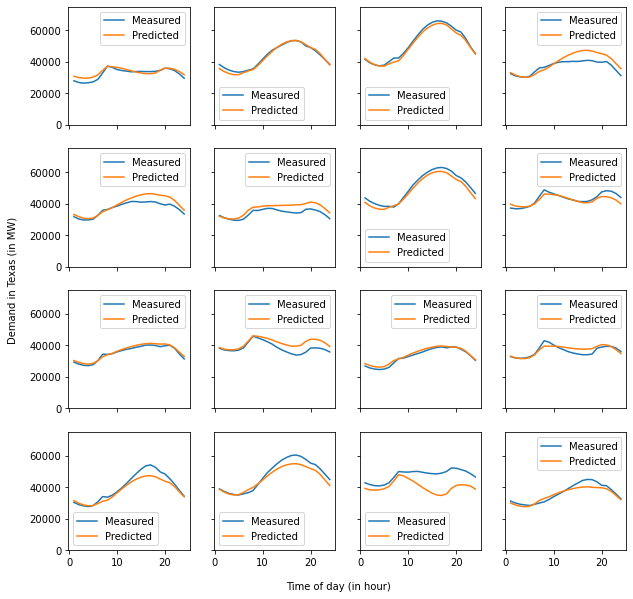

In [11]:
nHidden = 150

# Store the dimension of each row of 'X' in 'nDimX' and that of 'Y' in 'nDimY' .
nDimX = np.shape(trainX)[1]
nDimY = np.shape(trainY)[1]

# Construct the neural network using relu
inputs = keras.Input(shape=nDimX, name="input")
nn_layer = keras.layers.Dense(nHidden, activation="relu")(inputs)
nn_layer = keras.layers.Dense(nHidden, activation="relu")(nn_layer)
outputs = keras.layers.Dense(nDimY, name="output")(nn_layer)

model = keras.Model(inputs=inputs, outputs=outputs)

# Define the loss function (MSE) and the optimizer (AdagradOptimizer).

model.compile(
    optimizer=tf.optimizers.Adagrad(learning_rate=1),
    loss='mean_squared_error'
) 

# Train the model

print("Fit model on training data")

history = model.fit(
    trainX,
    trainY,
    batch_size = 50,
    epochs = 1000
)
# Output the accuracy of the regressor on the test data.

predictedY = model.predict(testX)

# Plot the predicted load and compare against the actual load from the test data.
assert(nTest >= 16)
days = random.sample(range(nTest), 16)

fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(10,10))
axs = axs.ravel()


for dd, day in enumerate(days):
    testYDay = testY[day]
    predictedYDay = predictedY[day]

    l1 = axs[dd].plot(range(1, 25), testYDay, label='Measured')
    l2 = axs[dd].plot(range(1, 25), predictedYDay, label='Predicted')
    
    axs[dd].set_ylim(bottom=0, top=75000)
    axs[dd].legend()

fig.text(0.5, 0.07, 'Time of day (in hour)', ha='center')
fig.text(0.04, 0.5, 'Demand in Texas (in MW)', va='center', rotation='vertical')

plt.show()

### The effect of wind energy (bonus).

Note that in addition to the load data, we have some wind data! 

**Question (20 points).** Subtract the wind data from the load, and redo the above experiment and observe how does wind energy affect the forecasting process. How does the accuracy change? Why?

**Your answer (comments here, code below).** The accuracy decreases obviously, even the experiment is conducted on the same setting with 1000 training epochs. I guess one explanation would be that wind is a very important source of energy (i.e. to produce electricity), thus the factors realted to wind (i.e. wind data) plays an extremely important role in the model, and elimination of them would reduce the model performance a lot (i.e. the new model cannot model the real case). Also, one thing worth mentioning is that with less factors to be considered, the performance curve becomes much more smooth (i.e. considering the curve of multipolinomial with less term).

In [12]:
#Let's check the raw data 
dfDemand = pd.read_csv("ERCOT_Hourly_Wind_Output_" + str(year) + ".csv")
dfDemand[:]

,time-date stamp,Date,"ERCOT Load, MW","Total Wind Output, MW","Total Wind Installed, MW","Wind Output, % of Load","Wind Output, % of Installed",1-hr MW change,1-hr % change
0,1/1/15 0:00,1-Jan,39932,871,12730,2.2,6.8,NaN,NaN
1,1/1/15 1:00,1-Jan,39134,724,12730,1.8,5.7,-147.0,-16.9
2,1/1/15 2:00,1-Jan,38560,596,12730,1.5,4.7,-127.0,-17.6
3,1/1/15 3:00,1-Jan,38334,486,12730,1.3,3.8,-110.0,-18.5
4,1/1/15 4:00,1-Jan,38392,651,12730,1.7,5.1,165.0,33.8
...,...,...,...,...,...,...,...,...,...
8755,12/31/15 19:00,31-Dec,39909,3825,16170,9.6,23.7,484.0,14.5
8756,12/31/15 20:00,31-Dec,38737,4626,16170,11.9,28.6,801.0,20.9
8757,12/31/15 21:00,31-Dec,37588,4958,16170,13.2,30.7,332.0,7.2
8758,12/31/15 22:00,31-Dec,36356,4699,16170,12.9,29.1,-259.0,-5.2


In [13]:
dfDemand.columns

Index(['time-date stamp', 'Date', 'ERCOT Load, MW', 'Total Wind Output, MW',
       'Total Wind Installed, MW', 'Wind Output, % of Load',
       'Wind Output, % of Installed', '1-hr MW change', '1-hr % change'],
      dtype='object')

In [14]:
dfDemand_clear = dfDemand.drop(columns=['Total Wind Output, MW','Total Wind Installed, MW', 'Wind Output, % of Load','Wind Output, % of Installed'])

In [15]:
dfDemand_clear

,time-date stamp,Date,"ERCOT Load, MW",1-hr MW change,1-hr % change
0,1/1/15 0:00,1-Jan,39932,NaN,NaN
1,1/1/15 1:00,1-Jan,39134,-147.0,-16.9
2,1/1/15 2:00,1-Jan,38560,-127.0,-17.6
3,1/1/15 3:00,1-Jan,38334,-110.0,-18.5
4,1/1/15 4:00,1-Jan,38392,165.0,33.8
...,...,...,...,...,...
8755,12/31/15 19:00,31-Dec,39909,484.0,14.5
8756,12/31/15 20:00,31-Dec,38737,801.0,20.9
8757,12/31/15 21:00,31-Dec,37588,332.0,7.2
8758,12/31/15 22:00,31-Dec,36356,-259.0,-5.2


In [16]:
daysToTrainOn = [-7, -2, -1]
rangeOfDays = range(-np.min(daysToTrainOn), numberOfDays)

X = [np.concatenate([dfDemand_clear.loc[(day + h) * 24: (day + h + 1) * 24 -1, 'ERCOT Load, MW'].values.flatten()
     for h in daysToTrainOn]) for day in rangeOfDays]
Y = [dfDemand_clear.loc[day * 24: (day + 1) * 24 - 1, 'ERCOT Load, MW'].values.flatten() for day in rangeOfDays]

X = preprocessing.StandardScaler().fit_transform(X)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2)

trainX = trainX.astype(np.float32)
testX = testX.astype(np.float32)
trainY = np.array(trainY)
testY = np.array(testY)

Fit model on training data
Epoch 1/1000
6/6 [==============================] - 0s 1ms/step - loss: 799503360.0000
Epoch 2/1000
6/6 [==============================] - 0s 2ms/step - loss: 323428352.0000
Epoch 3/1000
6/6 [==============================] - 0s 2ms/step - loss: 306269152.0000
Epoch 4/1000
6/6 [==============================] - 0s 4ms/step - loss: 279039072.0000
Epoch 5/1000
6/6 [==============================] - 0s 3ms/step - loss: 249352112.0000
Epoch 6/1000
6/6 [==============================] - 0s 3ms/step - loss: 211380416.0000
Epoch 7/1000
6/6 [==============================] - 0s 2ms/step - loss: 184805360.0000
Epoch 8/1000
6/6 [==============================] - 0s 2ms/step - loss: 158830032.0000
Epoch 9/1000
6/6 [==============================] - 0s 2ms/step - loss: 139602720.0000
Epoch 10/1000
6/6 [==============================] - 0s 2ms/step - loss: 117878848.0000
Epoch 11/1000
6/6 [==============================] - 0s 3ms/step - loss: 103327576.0000
Epoch 12/1000


6/6 [==============================] - 0s 1ms/step - loss: 23953888.0000
Epoch 95/1000
6/6 [==============================] - 0s 2ms/step - loss: 23831912.0000
Epoch 96/1000
6/6 [==============================] - 0s 1ms/step - loss: 23492462.0000
Epoch 97/1000
6/6 [==============================] - 0s 2ms/step - loss: 24163288.0000
Epoch 98/1000
6/6 [==============================] - 0s 2ms/step - loss: 22877004.0000
Epoch 99/1000
6/6 [==============================] - 0s 2ms/step - loss: 23002094.0000
Epoch 100/1000
6/6 [==============================] - 0s 1ms/step - loss: 23146432.0000
Epoch 101/1000
6/6 [==============================] - 0s 2ms/step - loss: 22183510.0000
Epoch 102/1000
6/6 [==============================] - 0s 1ms/step - loss: 21928120.0000
Epoch 103/1000
6/6 [==============================] - 0s 2ms/step - loss: 21951242.0000
Epoch 104/1000
6/6 [==============================] - 0s 1ms/step - loss: 21786516.0000
Epoch 105/1000
6/6 [==============================] 

6/6 [==============================] - 0s 5ms/step - loss: 9880628.0000
Epoch 188/1000
6/6 [==============================] - 0s 3ms/step - loss: 10998915.0000
Epoch 189/1000
6/6 [==============================] - 0s 2ms/step - loss: 9704057.0000
Epoch 190/1000
6/6 [==============================] - 0s 2ms/step - loss: 9695910.0000
Epoch 191/1000
6/6 [==============================] - 0s 3ms/step - loss: 10105354.0000
Epoch 192/1000
6/6 [==============================] - 0s 3ms/step - loss: 11133532.0000
Epoch 193/1000
6/6 [==============================] - 0s 4ms/step - loss: 9531243.0000
Epoch 194/1000
6/6 [==============================] - 0s 4ms/step - loss: 9344202.0000
Epoch 195/1000
6/6 [==============================] - 0s 3ms/step - loss: 9277743.0000
Epoch 196/1000
6/6 [==============================] - 0s 2ms/step - loss: 10068491.0000
Epoch 197/1000
6/6 [==============================] - 0s 5ms/step - loss: 10620869.0000
Epoch 198/1000
6/6 [==============================] -

6/6 [==============================] - 0s 1ms/step - loss: 6563063.0000
Epoch 282/1000
6/6 [==============================] - 0s 1ms/step - loss: 6273738.0000
Epoch 283/1000
6/6 [==============================] - 0s 2ms/step - loss: 6346580.0000
Epoch 284/1000
6/6 [==============================] - 0s 2ms/step - loss: 6632356.5000
Epoch 285/1000
6/6 [==============================] - 0s 1ms/step - loss: 6223987.5000
Epoch 286/1000
6/6 [==============================] - 0s 4ms/step - loss: 6427478.0000
Epoch 287/1000
6/6 [==============================] - 0s 2ms/step - loss: 6446135.0000
Epoch 288/1000
6/6 [==============================] - 0s 2ms/step - loss: 6398421.5000
Epoch 289/1000
6/6 [==============================] - 0s 1ms/step - loss: 6352556.5000
Epoch 290/1000
6/6 [==============================] - 0s 1ms/step - loss: 6466293.5000
Epoch 291/1000
6/6 [==============================] - 0s 2ms/step - loss: 6453950.0000
Epoch 292/1000
6/6 [==============================] - 0s 1

6/6 [==============================] - 0s 1ms/step - loss: 5193748.0000
Epoch 376/1000
6/6 [==============================] - 0s 1ms/step - loss: 5254787.5000
Epoch 377/1000
6/6 [==============================] - 0s 1ms/step - loss: 5524839.0000
Epoch 378/1000
6/6 [==============================] - 0s 1ms/step - loss: 5152062.5000
Epoch 379/1000
6/6 [==============================] - 0s 1ms/step - loss: 5239397.0000
Epoch 380/1000
6/6 [==============================] - 0s 2ms/step - loss: 5508004.0000
Epoch 381/1000
6/6 [==============================] - 0s 1ms/step - loss: 5328698.5000
Epoch 382/1000
6/6 [==============================] - 0s 1ms/step - loss: 5146345.0000
Epoch 383/1000
6/6 [==============================] - 0s 2ms/step - loss: 5107060.5000
Epoch 384/1000
6/6 [==============================] - 0s 2ms/step - loss: 5216934.0000
Epoch 385/1000
6/6 [==============================] - 0s 2ms/step - loss: 5352381.5000
Epoch 386/1000
6/6 [==============================] - 0s 2

6/6 [==============================] - 0s 2ms/step - loss: 5189425.0000
Epoch 470/1000
6/6 [==============================] - 0s 1ms/step - loss: 4691118.0000
Epoch 471/1000
6/6 [==============================] - 0s 1ms/step - loss: 4738528.0000
Epoch 472/1000
6/6 [==============================] - 0s 2ms/step - loss: 4671106.0000
Epoch 473/1000
6/6 [==============================] - 0s 2ms/step - loss: 4776107.5000
Epoch 474/1000
6/6 [==============================] - 0s 2ms/step - loss: 4808463.5000
Epoch 475/1000
6/6 [==============================] - 0s 2ms/step - loss: 4678031.0000
Epoch 476/1000
6/6 [==============================] - 0s 2ms/step - loss: 4649819.0000
Epoch 477/1000
6/6 [==============================] - 0s 2ms/step - loss: 4616084.5000
Epoch 478/1000
6/6 [==============================] - 0s 2ms/step - loss: 4608362.5000
Epoch 479/1000
6/6 [==============================] - 0s 1ms/step - loss: 4895240.5000
Epoch 480/1000
6/6 [==============================] - 0s 2

6/6 [==============================] - 0s 2ms/step - loss: 4331747.5000
Epoch 564/1000
6/6 [==============================] - 0s 2ms/step - loss: 4626323.5000
Epoch 565/1000
6/6 [==============================] - 0s 1ms/step - loss: 4409533.5000
Epoch 566/1000
6/6 [==============================] - 0s 2ms/step - loss: 4355507.0000
Epoch 567/1000
6/6 [==============================] - 0s 2ms/step - loss: 4583102.5000
Epoch 568/1000
6/6 [==============================] - 0s 2ms/step - loss: 4594031.0000
Epoch 569/1000
6/6 [==============================] - 0s 6ms/step - loss: 4454327.5000
Epoch 570/1000
6/6 [==============================] - 0s 4ms/step - loss: 4300959.0000
Epoch 571/1000
6/6 [==============================] - 0s 5ms/step - loss: 4651646.5000
Epoch 572/1000
6/6 [==============================] - 0s 5ms/step - loss: 4713290.5000
Epoch 573/1000
6/6 [==============================] - 0s 2ms/step - loss: 4317673.0000
Epoch 574/1000
6/6 [==============================] - 0s 2

6/6 [==============================] - 0s 3ms/step - loss: 4175248.0000
Epoch 658/1000
6/6 [==============================] - 0s 1ms/step - loss: 4128022.5000
Epoch 659/1000
6/6 [==============================] - 0s 1ms/step - loss: 4068412.0000
Epoch 660/1000
6/6 [==============================] - 0s 2ms/step - loss: 4147205.2500
Epoch 661/1000
6/6 [==============================] - 0s 2ms/step - loss: 4217269.0000
Epoch 662/1000
6/6 [==============================] - 0s 2ms/step - loss: 4181885.7500
Epoch 663/1000
6/6 [==============================] - ETA: 0s - loss: 4725686.000 - 0s 3ms/step - loss: 4270992.5000
Epoch 664/1000
6/6 [==============================] - 0s 4ms/step - loss: 4283128.5000
Epoch 665/1000
6/6 [==============================] - 0s 3ms/step - loss: 4094126.0000
Epoch 666/1000
6/6 [==============================] - 0s 4ms/step - loss: 4079160.5000
Epoch 667/1000
6/6 [==============================] - 0s 3ms/step - loss: 4261604.0000
Epoch 668/1000
6/6 [========

Epoch 751/1000
6/6 [==============================] - 0s 1ms/step - loss: 3950493.0000
Epoch 752/1000
6/6 [==============================] - 0s 1ms/step - loss: 4012583.0000
Epoch 753/1000
6/6 [==============================] - 0s 1ms/step - loss: 3893368.0000
Epoch 754/1000
6/6 [==============================] - 0s 1ms/step - loss: 3954906.0000
Epoch 755/1000
6/6 [==============================] - 0s 1ms/step - loss: 3970045.2500
Epoch 756/1000
6/6 [==============================] - 0s 1ms/step - loss: 4298176.5000
Epoch 757/1000
6/6 [==============================] - 0s 1ms/step - loss: 3905364.5000
Epoch 758/1000
6/6 [==============================] - 0s 1ms/step - loss: 3920578.7500
Epoch 759/1000
6/6 [==============================] - 0s 3ms/step - loss: 3987756.2500
Epoch 760/1000
6/6 [==============================] - 0s 2ms/step - loss: 3912049.2500
Epoch 761/1000
6/6 [==============================] - 0s 2ms/step - loss: 3953541.7500
Epoch 762/1000
6/6 [=======================

6/6 [==============================] - 0s 2ms/step - loss: 3793319.0000
Epoch 846/1000
6/6 [==============================] - 0s 2ms/step - loss: 3866283.7500
Epoch 847/1000
6/6 [==============================] - 0s 1ms/step - loss: 4172835.7500
Epoch 848/1000
6/6 [==============================] - 0s 1ms/step - loss: 3764714.0000
Epoch 849/1000
6/6 [==============================] - 0s 1ms/step - loss: 3903975.0000
Epoch 850/1000
6/6 [==============================] - 0s 1ms/step - loss: 3897771.0000
Epoch 851/1000
6/6 [==============================] - 0s 2ms/step - loss: 3888785.5000
Epoch 852/1000
6/6 [==============================] - 0s 2ms/step - loss: 3751848.2500
Epoch 853/1000
6/6 [==============================] - 0s 1ms/step - loss: 3980426.2500
Epoch 854/1000
6/6 [==============================] - 0s 1ms/step - loss: 3786364.0000
Epoch 855/1000
6/6 [==============================] - 0s 1ms/step - loss: 3907486.5000
Epoch 856/1000
6/6 [==============================] - 0s 1

6/6 [==============================] - 0s 1ms/step - loss: 3818175.0000
Epoch 940/1000
6/6 [==============================] - 0s 1ms/step - loss: 3680239.5000
Epoch 941/1000
6/6 [==============================] - 0s 1ms/step - loss: 3710886.5000
Epoch 942/1000
6/6 [==============================] - 0s 1ms/step - loss: 3883074.7500
Epoch 943/1000
6/6 [==============================] - 0s 1ms/step - loss: 3640016.5000
Epoch 944/1000
6/6 [==============================] - 0s 1ms/step - loss: 3631316.2500
Epoch 945/1000
6/6 [==============================] - 0s 1ms/step - loss: 3640453.5000
Epoch 946/1000
6/6 [==============================] - 0s 1ms/step - loss: 3668141.2500
Epoch 947/1000
6/6 [==============================] - 0s 1ms/step - loss: 3670758.0000
Epoch 948/1000
6/6 [==============================] - 0s 1ms/step - loss: 3610859.2500
Epoch 949/1000
6/6 [==============================] - 0s 1ms/step - loss: 3720220.7500
Epoch 950/1000
6/6 [==============================] - 0s 1

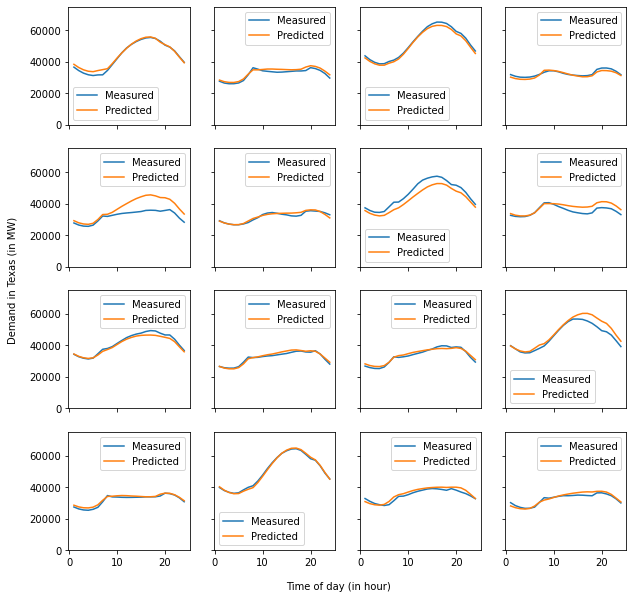

In [17]:
nHidden = 150

# Store the dimension of each row of 'X' in 'nDimX' and that of 'Y' in 'nDimY' .
nDimX = np.shape(trainX)[1]
nDimY = np.shape(trainY)[1]

# Construct the neural network using relu
inputs = keras.Input(shape=nDimX, name="input")
nn_layer = keras.layers.Dense(nHidden, activation="relu")(inputs)
outputs = keras.layers.Dense(nDimY, name="output")(nn_layer)

model = keras.Model(inputs=inputs, outputs=outputs)

# Define the loss function (MSE) and the optimizer (AdagradOptimizer).

model.compile(
    optimizer=tf.optimizers.Adagrad(learning_rate=1),
    loss='mean_squared_error'
) 

# Train the model

print("Fit model on training data")

history = model.fit(
    trainX,
    trainY,
    batch_size = 50,
    epochs = 1000
)
# Output the accuracy of the regressor on the test data.

predictedY = model.predict(testX)

# Plot the predicted load and compare against the actual load from the test data.
assert(nTest >= 16)
days = random.sample(range(nTest), 16)

fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(10,10))
axs = axs.ravel()


for dd, day in enumerate(days):
    testYDay = testY[day]
    predictedYDay = predictedY[day]

    l1 = axs[dd].plot(range(1, 25), testYDay, label='Measured')
    l2 = axs[dd].plot(range(1, 25), predictedYDay, label='Predicted')
    
    axs[dd].set_ylim(bottom=0, top=75000)
    axs[dd].legend()

fig.text(0.5, 0.07, 'Time of day (in hour)', ha='center')
fig.text(0.04, 0.5, 'Demand in Texas (in MW)', va='center', rotation='vertical')

plt.show()